# Import Neccessry libraries

In [125]:
from nltk.corpus import stopwords,reuters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,classification_report
import os,re
import warnings
warnings.filterwarnings('ignore')
import nltk 
import pickle
import tensorflow as tf
from tqdm import tqdm, trange
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel

In [126]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

In [127]:
device =  torch.device('cpu')

In [128]:
#the path that we will save best weights in 
model_path = "C:\\Users\\cccc\\TextClassıfıcatıon\\Reuters_best_weights.pt"

# Load and Preprocess Training Data

In [129]:
ReutersDf =  pd.read_excel('reutersNLTK.xlsx')
ReutersDf.tail()

,ids,categories,text
10783,training/999,"['interest', 'money-fx']",U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...
10784,training/9992,['earn'],KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY\n Q...
10785,training/9993,['earn'],TECHNITROL INC &lt;TNL> SETS QUARTERLY\n Qtly...
10786,training/9994,['earn'],NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...
10787,training/9995,['earn'],&lt;A.H.A. AUTOMOTIVE TECHNOLOGIES CORP> YEAR ...


In [130]:
#encode multi-label per instance
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()


In [132]:
len(label_names)

91

In [133]:
# splitting data into training and testing
from sklearn.model_selection import train_test_split
ReutersDf_train, ReutersDf_test = train_test_split(arab_df, test_size=0.20)

In [134]:
import re
#preprocess step
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', str(sentence))

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', str(sentence))

    return sentence

In [135]:
ReutersDf_train.loc[:,"text"] = ReutersDf_train.text.apply(lambda x: preprocess_text(x))
ReutersDf_test.loc[:,"text"] = ReutersDf_test.text.apply(lambda x: preprocess_text(x))

#encode multi-label per instance and 
labels = list(mlb.fit_transform(ReutersDf_train["categories"]))
newsitems = list(ReutersDf_train.text.values)

test_labels = list(mlb.fit_transform(ReutersDf_test["categories"]))
test_newsitems = list(ReutersDf_test.text.values)

In [136]:
print('Null values: ', ReutersDf_train.isnull().values.any())
# print(rcv1_train.isnull().sum())

Null values:  False


In [137]:
print('Null values: ', ReutersDf_test.isnull().values.any())


Null values:  False


In [138]:
print('average train sentence length: ', ReutersDf_train.text.str.split().str.len().mean())
print('stdev train sentence length: ', ReutersDf_train.text.str.split().str.len().std())

average train sentence length:  119.38018539976825
stdev train sentence length:  131.22225531044342


In [139]:
print('average train sentence length: ', ReutersDf_test.text.str.split().str.len().mean())
print('stdev train sentence length: ', ReutersDf_test.text.str.split().str.len().std())

average train sentence length:  117.42585727525487
stdev train sentence length:  126.35455343750864


# Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:

In [140]:
import seaborn as sb
ReutersDf_train['text_len'] = ReutersDf_train.loc[:,'text'].apply(lambda x:len(x.split()))
sb.displot(ReutersDf_train.text_len,bins=512)

In [141]:
#initalise max length , bert tokenizer and encoding train data
#less length in order to avoid memory error
max_length = 200
ReutersDf_train = ReutersDf_train.reset_index(drop=True)
# Select a batch size for training. For fine-tuning with Bert, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
encodings = tokenizer.batch_encode_plus(newsitems,max_length=max_length,pad_to_max_length=True,truncation=True)

In [142]:
# loading necessary encoded values 
input_ids = encodings['input_ids'] 
token_type_ids = encodings['token_type_ids'] 
attention_masks = encodings['attention_mask']

In [143]:
# splitting data into training and validation
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels,
token_type_ids,attention_masks, random_state=200, test_size=0.10)

In [144]:
# converting all numpy arrays to tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [145]:
# creating data loader and loading data into it using random sampler
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [146]:
# saving data loaders
torch.save(validation_dataloader,'validation_Rueters_data_loader')
torch.save(train_dataloader,'train_Rueters_data_loader')

In [157]:
# loading pretrained BERT model
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-cased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 32)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [158]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [159]:
# initialising optimizer
from torch.optim import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [160]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [161]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=5, path=model_path, verbose=True)

# Training and Validation

In [163]:
val_acc_list = []
# Store our loss and accuracy for plotting
train_loss_set = []
valid_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs =50

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # set model to training mode 
    model.train()
    
    # Tracking variables of traning
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
    
     # Tracking variables of validation
    vl_loss = 0 #running loss
    nb_vl_examples, nb_vl_steps = 0, 0

    # train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        # clearing the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(b_input_ids, b_input_mask ,b_token_types)
        logits = outputs
        loss_func = BCEWithLogitsLoss()
        # converting logits and labels to appropriate shape 
        loss = loss_func(logits.view(-1,32),b_labels.type_as(logits).view(-1,32)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    


        # backward pass
        loss.backward()
        # update parameters and take a step using the computed gradient
        optimizer.step()
        
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    #################################################################
    #validation 
    
    # set model to evaluation mode
    model.eval()
    
    # variables to gather outputs
    logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]


    # predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch) 
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        with torch.no_grad():
            # forward pass
            outs = model(b_input_ids, b_input_mask ,b_token_types)
            # Calculate Validation Loss
            logits_val = outs
            
            loss_func_val = BCEWithLogitsLoss() 
            loss_val = loss_func_val(logits_val.view(-1,32),b_labels.type_as(logits_val).view(-1,32)) #convert labels to float for calculation
            valid_loss_set.append(loss_val.item())
            
            vl_loss += loss_val.item()
            nb_vl_examples += b_input_ids.size(0)
            nb_vl_steps += 1

            b_logit_pred = outs
            pred_label = torch.sigmoid(b_logit_pred)

            # converting tensors to numpy arrays
            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
            
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
        
    print("Validation loss: {}".format(vl_loss/nb_vl_steps))
    
    # flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]
    
    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(vl_loss/nb_vl_steps, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

Train loss: 0.14606736895509462
Validation loss: 0.13593660101846414
F1 Validation Accuracy:  90.72004526807187
Flat Validation Accuracy:  66.85979142526072
Validation loss decreased (inf --> 0.135937).  Saving model ...


Epoch:   2%|█▍                                                                     | 1/50 [42:52<35:01:09, 2572.84s/it]

Train loss: 0.11008711674714407
Validation loss: 0.11185028707539593
F1 Validation Accuracy:  92.73308322912325
Flat Validation Accuracy:  72.65353418308227
Validation loss decreased (0.135937 --> 0.111850).  Saving model ...


Epoch:   4%|██▊                                                                  | 2/50 [1:25:42<34:16:58, 2571.23s/it]

Train loss: 0.08678889751181375
Validation loss: 0.10339010051555103
F1 Validation Accuracy:  92.98306738206396
Flat Validation Accuracy:  73.81228273464659
Validation loss decreased (0.111850 --> 0.103390).  Saving model ...


Epoch:   6%|████▏                                                                | 3/50 [2:08:37<33:35:18, 2572.72s/it]

Train loss: 0.07195581348589909
Validation loss: 0.10025988908967486
F1 Validation Accuracy:  93.68314833501515
Flat Validation Accuracy:  76.70915411355736
Validation loss decreased (0.103390 --> 0.100260).  Saving model ...


Epoch:   8%|█████▌                                                               | 4/50 [2:51:32<32:53:14, 2573.80s/it]

Train loss: 0.059232286714140034
Validation loss: 0.09194136072916013
F1 Validation Accuracy:  94.24597763839651
Flat Validation Accuracy:  78.91077636152954
Validation loss decreased (0.100260 --> 0.091941).  Saving model ...


Epoch:  10%|██████▉                                                              | 5/50 [3:34:27<32:10:30, 2574.02s/it]

Train loss: 0.05022330972684141
Validation loss: 0.09031410127257307
F1 Validation Accuracy:  94.37821728528853
Flat Validation Accuracy:  79.60602549246813
Validation loss decreased (0.091941 --> 0.090314).  Saving model ...


Epoch:  12%|████████▎                                                            | 6/50 [4:17:19<31:27:06, 2573.34s/it]

Train loss: 0.04263315212610082


Epoch:  14%|█████████▋                                                           | 7/50 [4:59:56<30:40:31, 2568.17s/it]

Validation loss: 0.0907512977719307
F1 Validation Accuracy:  94.3118264902469
Flat Validation Accuracy:  79.4901506373117
EarlyStopping counter: 1 out of 5
Train loss: 0.0373035478491888
Validation loss: 0.08762399723787827
F1 Validation Accuracy:  94.75741239892183
Flat Validation Accuracy:  80.76477404403245
Validation loss decreased (0.090314 --> 0.087624).  Saving model ...


Epoch:  16%|███████████                                                          | 8/50 [5:42:48<29:58:35, 2569.42s/it]

Train loss: 0.03251379196735198
Validation loss: 0.08664517234838395
F1 Validation Accuracy:  94.60694075134657
Flat Validation Accuracy:  80.9965237543453
Validation loss decreased (0.087624 --> 0.086645).  Saving model ...


Epoch:  18%|████████████▍                                                        | 9/50 [6:25:44<29:17:03, 2571.30s/it]

Train loss: 0.028469390810731753


Epoch:  20%|█████████████▌                                                      | 10/50 [7:08:38<28:34:43, 2572.08s/it]

Validation loss: 0.08728053715700905
F1 Validation Accuracy:  94.69558753969864
Flat Validation Accuracy:  80.76477404403245
EarlyStopping counter: 1 out of 5
Train loss: 0.025779434219635102


Epoch:  22%|██████████████▉                                                     | 11/50 [7:51:31<27:52:02, 2572.36s/it]

Validation loss: 0.09131171269756225
F1 Validation Accuracy:  94.5334590009425
Flat Validation Accuracy:  80.76477404403245
EarlyStopping counter: 2 out of 5
Train loss: 0.022247296099746485


Epoch:  24%|████████████████▎                                                   | 12/50 [8:34:24<27:09:24, 2572.75s/it]

Validation loss: 0.09624832454654905
F1 Validation Accuracy:  94.58367016976555
Flat Validation Accuracy:  80.88064889918888
EarlyStopping counter: 3 out of 5
Train loss: 0.02228308955797688


Epoch:  26%|█████████████████▋                                                  | 13/50 [9:17:19<26:26:48, 2573.19s/it]

Validation loss: 0.09131668721049747
F1 Validation Accuracy:  94.83402348788269
Flat Validation Accuracy:  82.8505214368482
EarlyStopping counter: 4 out of 5
Train loss: 0.018055172274205375


Epoch:  26%|█████████████████▍                                                 | 13/50 [10:00:14<28:28:22, 2770.34s/it]

Validation loss: 0.09776448686089781
F1 Validation Accuracy:  94.31894131800561
Flat Validation Accuracy:  80.76477404403245
EarlyStopping counter: 5 out of 5
Early stopping


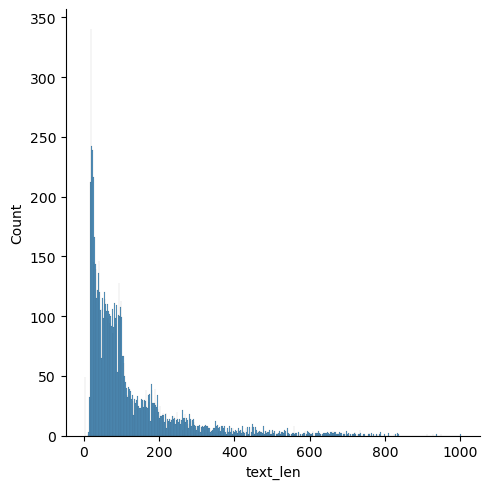

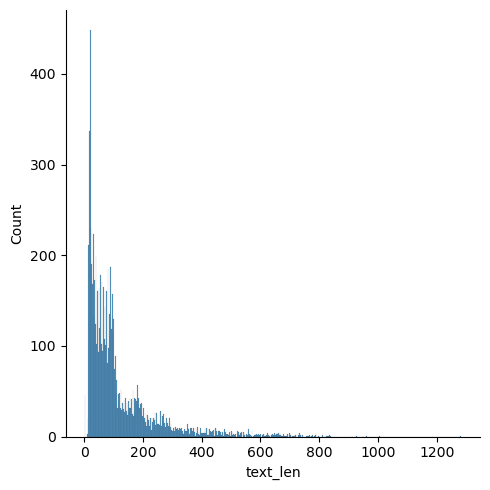

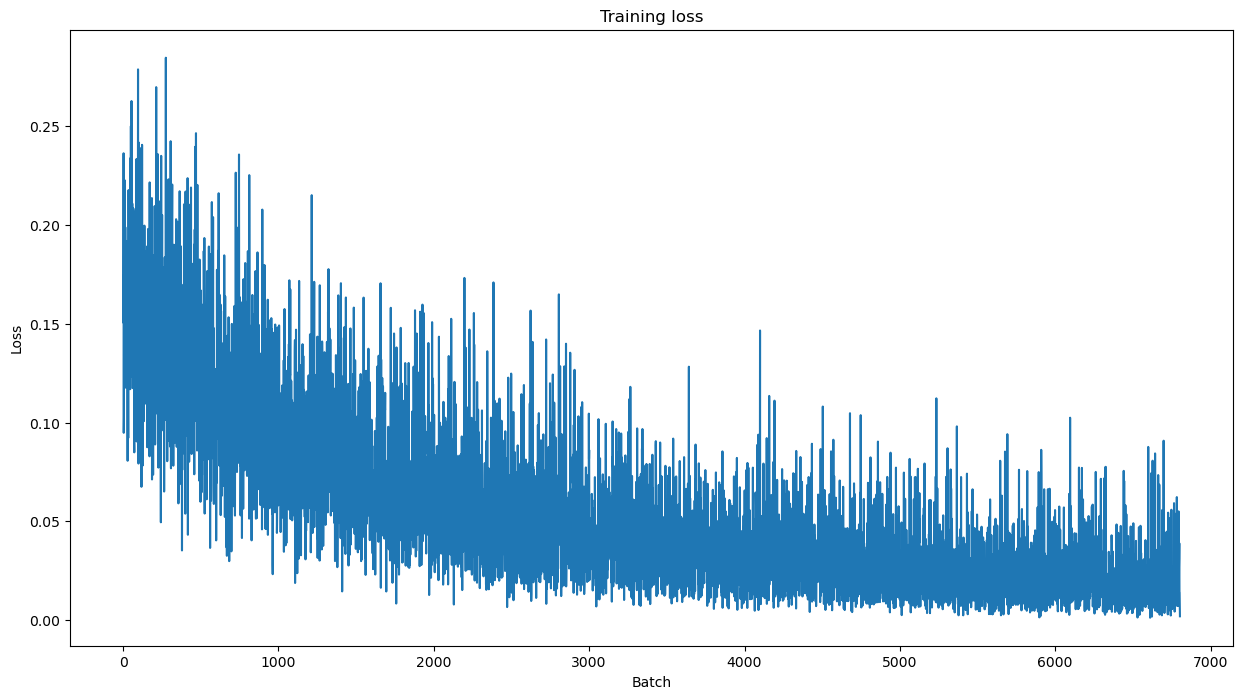

In [164]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [165]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [166]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_newsitems,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [167]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Testing The Model

In [168]:
# testing 

# put model in evaluation mode 
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]

# predict
# reading input from each batch
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from test dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
        # forward pass
        outs = model(b_input_ids, b_input_mask ,b_token_types)
        b_logit_pred = outs
        pred_label = torch.sigmoid(b_logit_pred)

        # converting into numpy arrays 
        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()
        
    # appending output variables 
    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    pred_labels.append(pred_label)  
    true_labels.append(b_labels) 
    
# flatten output variables
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
 
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [170]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools)
pickle.dump(clf_report, open('Reuters_Bert_Text_Classification_report.txt','wb'))
print(clf_report)

Test F1 Accuracy:  0.9547352412553574
Test Flat Accuracy:  0.8373493975903614 

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       326
           1       1.00      1.00      1.00      2158
           2       0.78      0.71      0.74       326
           3       0.89      0.85      0.87       256
           4       1.00      1.00      1.00      2158
           5       1.00      1.00      1.00      2158
           6       0.98      0.98      0.98      1638
           7       0.75      0.90      0.82        72
           8       0.97      0.97      0.97       740
           9       0.88      0.88      0.88       317
          10       0.98      0.98      0.98      1467
          11       0.91      0.86      0.88       187
          12       0.94      0.85      0.89       269
          13       0.91      0.80      0.86       133
          14       0.94      0.87      0.90       389
          15       1.00      0.57      0.73        14
 

In [171]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. First with 'macro_thresholds' on the order of e^-1 then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, flat_acc_results = [], []
for th in macro_thresholds:
    pred_bools = [pl>th for pl in pred_labels]
    test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
    test_flat_accuracy = accuracy_score(true_bools, pred_bools)
    f1_results.append(test_f1_accuracy)
    flat_acc_results.append(test_flat_accuracy)

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
    pred_bools = [pl>th for pl in pred_labels]
    test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
    test_flat_accuracy = accuracy_score(true_bools, pred_bools)
    f1_results.append(test_f1_accuracy)
    flat_acc_results.append(test_flat_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Accuracy: ', f1_results[best_f1_idx])
print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools)
pickle.dump(clf_report_optimized, open('Reuters_Bert_Text_Classification_report_optimized.txt','wb'))
print(clf_report_optimized)

Best Threshold:  0.41000000000000003
Test F1 Accuracy:  0.955564099747336
Test Flat Accuracy:  0.8410565338276181 

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       326
           1       1.00      1.00      1.00      2158
           2       0.77      0.74      0.76       326
           3       0.89      0.89      0.89       256
           4       1.00      1.00      1.00      2158
           5       1.00      1.00      1.00      2158
           6       0.98      0.98      0.98      1638
           7       0.74      0.92      0.82        72
           8       0.96      0.97      0.97       740
           9       0.86      0.89      0.88       317
          10       0.98      0.99      0.98      1467
          11       0.90      0.86      0.88       187
          12       0.94      0.87      0.90       269
          13       0.91      0.80      0.85       133
          14       0.93      0.89      0.91       389
          15       